In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from IPython.display import display, HTML
from enum import *

In [2]:
nombreArchivoDatasetEntrenamiento = "./train.csv"
nombreArchivoDatasetPrueba = "./test.csv"
nombreArchivoSalidasPrueba = "./gender_submission.csv"
etiquetaFrecuencia = "Frecuencia"
etiquetaFrecuenciaAbsoluta = "Frecuencia Absoluta"
etiquetaFrecuenciaRelativa = "Frecuencia Relativa"
etiquetaTotalGeneral = "Total General"
nombreColumnaSalida = "Survived"
nombreColumnaDuplicadaSalida = "Survived2"

In [3]:
def buildFrequenciesTableFor1DiscreteVariable(dataframeSource, targetColumn, labelAbsoluteFrequency = "Absolute Frequency", labelRelativeFrequency = "Relative Frequency", labelGeneralTotal = "General Total"):
    #Construccion inicial de la tabla de frecuencias (no se cuenta con el total general)
    fullFrequenciesTable = dataframeSource.groupby([targetColumn]).size().reset_index(name = labelAbsoluteFrequency)
    variableNumberValues = len(fullFrequenciesTable)
    
    #Obtencion del total general (Suma de los valores que se tienen columna por columna)
    valuesSumTableByColumns = fullFrequenciesTable.sum()
    valuesSumTableByColumns.name = ""
    totalValuesList = valuesSumTableByColumns.tolist()
    valuesSumTableByColumns = pd.DataFrame({}, columns = fullFrequenciesTable.columns)
    valuesSumTableByColumns.loc[0] = totalValuesList
    valuesSumTableByColumns.iloc[0, 0] = labelGeneralTotal
    fullFrequenciesTable = pd.concat([fullFrequenciesTable, valuesSumTableByColumns], axis = 0).reset_index(drop = True)
    fullFrequenciesTable.index = fullFrequenciesTable[targetColumn]
    fullFrequenciesTable.drop(targetColumn, inplace = True, axis = 1)
    
    #Obtencion de frecuencias relativas
    valuesTotalCount = fullFrequenciesTable.loc[fullFrequenciesTable.index[variableNumberValues], labelAbsoluteFrequency]
    relativeFrequenciesList = [absoluteFrequency / valuesTotalCount for absoluteFrequency in fullFrequenciesTable["Frecuencia Absoluta"].tolist()]
    fullFrequenciesTable[labelRelativeFrequency] = relativeFrequenciesList
    
    #Obtencion de celdas cuyo valor es el minimo en la frecuencia absoluta (y por lo tanto es el minimo en la frecuencia relativa)
    cellsIndexesWithMinimumValueBySelectedColumns = {labelAbsoluteFrequency: [], labelRelativeFrequency: []}
    minimumValue = float('inf')
    indexesListWithMinimumValue = []
    for rowIndex in range(len(fullFrequenciesTable) - 1):
        if fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex] < minimumValue:
            minimumValue = fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex]
            indexesListWithMinimumValue = [rowIndex]
        elif fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex] == minimumValue:
            indexesListWithMinimumValue.append(rowIndex)
    cellsIndexesWithMinimumValueBySelectedColumns[labelAbsoluteFrequency] = indexesListWithMinimumValue
    cellsIndexesWithMinimumValueBySelectedColumns[labelRelativeFrequency] = indexesListWithMinimumValue
    
    #Obtencion de celdas cuyo valor es el maximo en la frecuencia absoluta (y por lo tanto es el maximo en la frecuencia relativa)
    cellsIndexesWithMaximumValueBySelectedColumns = {labelAbsoluteFrequency: [], labelRelativeFrequency: []}
    maximumValue = -1
    indexesListWithMaximumValue = []
    for rowIndex in range(len(fullFrequenciesTable) - 1):
        if fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex] > maximumValue:
            maximumValue = fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex]
            indexesListWithMaximumValue = [rowIndex]
        elif fullFrequenciesTable[labelAbsoluteFrequency].tolist()[rowIndex] == maximumValue:
            indexesListWithMaximumValue.append(rowIndex)
    cellsIndexesWithMaximumValueBySelectedColumns[labelAbsoluteFrequency] = indexesListWithMaximumValue
    cellsIndexesWithMaximumValueBySelectedColumns[labelRelativeFrequency] = indexesListWithMaximumValue
    return fullFrequenciesTable, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns

def buildFrequenciesTableFor2DiscreteVariables(dataframeSource, valuesColumn, indexColumn, grouppingColumn, labelGeneralTotal = "General Total"):
    #Construccion inicial de la tabla dinamica, al nivel de detalle indicado (no se cuenta con el total general)
    fullPivotTable = pd.pivot_table(dataframeSource, values = valuesColumn, index = indexColumn, columns = grouppingColumn, aggfunc = 'count')
    fullPivotTable.fillna(0.0, inplace = True)
    fullPivotTable[labelGeneralTotal] = fullPivotTable[fullPivotTable.columns].sum(axis = 1) #Suma de los valores que se tienen fila por fila
    
    #Obtencion del total general (Suma de los valores que se tienen columna por columna)
    valuesSumTableByColumns = fullPivotTable.sum()
    valuesSumTableByColumns.name = labelGeneralTotal
    totalValuesList = valuesSumTableByColumns.tolist()
    valuesSumTableByColumns = pd.DataFrame({}, columns = fullPivotTable.columns, index = pd.Index([], name = indexColumn))
    valuesSumTableByColumns.loc[labelGeneralTotal] = totalValuesList
    fullPivotTable = pd.concat([fullPivotTable, valuesSumTableByColumns], axis = 0)
    
    for column in fullPivotTable.columns:
        fullPivotTable[column] = [int(value) for value in fullPivotTable[column].tolist()]
    
    #Obtencion de celdas al nivel de detalle principal, cuyo valor es 0
    cellsIndexesWithZeroValuesBySelectedColumns = {}
    for column in fullPivotTable.columns:
        cellsIndexesWithZeroValuesBySelectedColumns[column] = []
        for rowIndex in range(len(fullPivotTable) - 1):
            if fullPivotTable[column].tolist()[rowIndex] == 0:
                cellsIndexesWithZeroValuesBySelectedColumns[column].append(rowIndex)
    
    #Obtencion de celdas al nivel de detalle principal, cuyo valor es el minimo en cada columna (cada valor posible en el nivel de detalle principal y no se toma en cuenta la fila del total general)
    cellsIndexesWithMinimumValueBySelectedColumns = {}
    for column in fullPivotTable.columns:
        cellsIndexesWithMinimumValueBySelectedColumns[column] = []
        minimumValue = float('inf')
        indexesListWithMinimumValue = []
        for rowIndex in range(len(fullPivotTable) - 1):
            if fullPivotTable[column].tolist()[rowIndex] < minimumValue and fullPivotTable[column].tolist()[rowIndex] != 0:
                minimumValue = fullPivotTable[column].tolist()[rowIndex]
                indexesListWithMinimumValue = [rowIndex]
            elif fullPivotTable[column].tolist()[rowIndex] == minimumValue:
                indexesListWithMinimumValue.append(rowIndex)
        cellsIndexesWithMinimumValueBySelectedColumns[column] = indexesListWithMinimumValue
    
    #Obtencion de celdas cuyo valor es el minimo en la ultima fila (Sin incluir la ultima casilla que indica el numero total de observaciones)
    minimumValue = float('inf')
    indexesListWithMinimumValueInLastRow = []
    for columnIndex in range(len(fullPivotTable.columns) - 1):
        if fullPivotTable.iloc[-1].tolist()[columnIndex] < minimumValue and fullPivotTable.iloc[-1].tolist()[columnIndex] != 0:
            minimumValue = fullPivotTable.iloc[-1].tolist()[columnIndex]
            indexesListWithMinimumValueInLastRow = [columnIndex]
        elif fullPivotTable.iloc[-1].tolist()[columnIndex] == minimumValue:
            indexesListWithMinimumValueInLastRow.append(columnIndex)
    for columnIndex in indexesListWithMinimumValueInLastRow:
        cellsIndexesWithMinimumValueBySelectedColumns[fullPivotTable.columns[columnIndex]] += [len(fullPivotTable) - 1]
    
    #Obtencion de celdas al nivel de detalle principal, cuyo valor es el maximo en cada columna (cada valor posible en el nivel de detalle principal y no se toma en cuenta la fila del total general)
    cellsIndexesWithMaximumValueBySelectedColumns = {}
    for column in fullPivotTable.columns:
        cellsIndexesWithMaximumValueBySelectedColumns[column] = []
        maximumValue = -1
        indexesListWithMaximumValue = []
        for rowIndex in range(len(fullPivotTable) - 1):
            if fullPivotTable[column].tolist()[rowIndex] > maximumValue and fullPivotTable[column].tolist()[rowIndex] != 0:
                maximumValue = fullPivotTable[column].tolist()[rowIndex]
                indexesListWithMaximumValue = [rowIndex]
            elif fullPivotTable[column].tolist()[rowIndex] == maximumValue:
                indexesListWithMaximumValue.append(rowIndex)
        cellsIndexesWithMaximumValueBySelectedColumns[column] = indexesListWithMaximumValue
    
    #Obtencion de celdas cuyo valor es el maximo en la ultima fila (Sin incluir la ultima casilla que indica el numero total de observaciones)
    maximumValue = -1
    indexesListWithMaximumValueInLastRow = []
    for columnIndex in range(len(fullPivotTable.columns) - 1):
        if fullPivotTable.iloc[-1].tolist()[columnIndex] > maximumValue and fullPivotTable.iloc[-1].tolist()[columnIndex] != 0:
            maximumValue = fullPivotTable.iloc[-1].tolist()[columnIndex]
            indexesListWithMaximumValueInLastRow = [columnIndex]
        elif fullPivotTable.iloc[-1].tolist()[columnIndex] == maximumValue:
            indexesListWithMaximumValueInLastRow.append(columnIndex)
    for columnIndex in indexesListWithMaximumValueInLastRow:
        cellsIndexesWithMaximumValueBySelectedColumns[fullPivotTable.columns[columnIndex]] += [len(fullPivotTable) - 1]
    return fullPivotTable, cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns

def plotFrequenciesProportionFor1Variable(frequenciesTableFor1Variable, targetColumn, labelAbsoluteFrequency, labelRelativeFrequency):
    variableNumberValues = len(frequenciesTableFor1Variable) - 1
    labelsList = [str(frequenciesTableFor1Variable.loc[frequenciesTableFor1Variable.index[index], labelAbsoluteFrequency]) + " (" + str(np.round(100 * frequenciesTableFor1Variable.loc[frequenciesTableFor1Variable.index[index], labelRelativeFrequency], decimals = 3)) + " %)" for index in range(variableNumberValues)]
    
    #Obtencion de la gama de colores para las barras/sectores circulares
    barsColorsListInHexadecimal = None
    if variableNumberValues <= len(px.colors.qualitative.Pastel1):
        barsColorsListInRGB = [color.replace("rgb(", "").replace(")", "") for color in px.colors.qualitative.Pastel1]
        barsColorsListInRGB = [color.split(",") for color in barsColorsListInRGB]
        barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(component[0]), int(component[1]), int(component[2])) for component in barsColorsListInRGB]
    else:
        colorsMap = mpl.cm.get_cmap('turbo')
        barsColorsListInRGB = [colorsMap(number) for number in list(np.linspace(0.0, 1.0, num = variableNumberValues))]
        barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(255 * component[0]), int(255 * component[1]), int(255 * component[2])) for component in barsColorsListInRGB]
    
    #Construccion de la grafica de pastel
    plotTitle = "Proporción y Distribución de Frecuencias de\n" + targetColumn
    plt.pie(frequenciesTableFor1Variable[labelAbsoluteFrequency].tolist()[:variableNumberValues], labels = labelsList, colors = barsColorsListInHexadecimal, wedgeprops = {"linewidth": 1.0, "edgecolor": "black"})
    plt.title(plotTitle)
    plt.legend(frequenciesTableFor1Variable.index[:variableNumberValues], title = targetColumn, bbox_to_anchor = (1.35, 0.5), loc = "center left")
    plt.tight_layout()

def plotFrequenciesDistributionFor2Variables(frequenciesTableFor2Variables, mainVariableName, secondaryVariableName, barWidth = 1.0, barOffset = 0.0, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = "Frequency"):
    firstVariableNumberValues = len(frequenciesTableFor2Variables) - 1
    secondVariableNumberValues = len(frequenciesTableFor2Variables.columns) - 1
    firstVariableValuesList = list(frequenciesTableFor2Variables.index)[:firstVariableNumberValues]
    secondVariableValuesList = list(frequenciesTableFor2Variables.columns)[:secondVariableNumberValues]
    
    #Calculo de alturas de las barras respecto a la variable indicada
    barsHeightsListsGroupedByFirstVariable = {value: list(frequenciesTableFor2Variables.loc[value, frequenciesTableFor2Variables.columns[:secondVariableNumberValues]]) for value in firstVariableValuesList}
    barsHeightsListsGroupedBySecondVariable = {value: list(frequenciesTableFor2Variables.loc[frequenciesTableFor2Variables.index[:firstVariableNumberValues], value]) for value in secondVariableValuesList}
    
    #Calculo de posiciones de las barras respecto a la variable indicada
    barsPositionsListsGroupedByFirstVariable = {value: [(index * (len(firstVariableValuesList) + 1) + firstVariableValuesList.index(value)) * barWidth + index * barOffset for index in list(np.arange(secondVariableNumberValues))] for value in firstVariableValuesList}
    barsPositionsListsGroupedBySecondVariable = {value: [(index * (len(secondVariableValuesList) + 1) + secondVariableValuesList.index(value)) * barWidth + index * barOffset for index in list(np.arange(firstVariableNumberValues))] for value in secondVariableValuesList}
    
    #Calculo de posiciones de las etiquetas de valores de la variable indicada
    firstAndLastBarsPositionsListGroupedBySecondVariable = {value: [(secondVariableValuesList.index(value) * (len(firstVariableValuesList) + 1)) * barWidth + secondVariableValuesList.index(value) * barOffset, ((secondVariableValuesList.index(value) + 1) * (len(firstVariableValuesList) + 1) - 1) * barWidth + secondVariableValuesList.index(value) * barOffset] for value in secondVariableValuesList}
    firstAndLastBarsPositionsListGroupedByFirstVariable = {value: [(firstVariableValuesList.index(value) * (len(secondVariableValuesList) + 1)) * barWidth + firstVariableValuesList.index(value) * barOffset, ((firstVariableValuesList.index(value) + 1) * (len(secondVariableValuesList) + 1) - 1) * barWidth + firstVariableValuesList.index(value) * barOffset] for value in firstVariableValuesList}
    barsLabelsListGroupedBySecondVariable = [np.mean(firstAndLastBarsPositionsListGroupedBySecondVariable[value]) for value in secondVariableValuesList]
    barsLabelsListGroupedByFirstVariable = [np.mean(firstAndLastBarsPositionsListGroupedByFirstVariable[value]) for value in firstVariableValuesList]
    
    #Obtencion de valores de parametros para la grafica del diagrama de barras agrupadas
    barsColorsListInHexadecimal = None
    barsHeightsListsGroupedByIndicatedVariable = None
    barsPositionsListsGroupedByIndicatedVariable = None
    legendLabelsValuesList = None
    plotXLabelsPositionsList = None
    plotXLabelsValuesList = None
    plotTitle = None
    plotXLabel = None
    legendTitle = None
    if mainVariableAtLegend == True:
        #Obtencion de la gama de colores para las barras/sectores circulares
        if secondVariableNumberValues <= len(px.colors.qualitative.Pastel1):
            barsColorsListInRGB = [color.replace("rgb(", "").replace(")", "") for color in px.colors.qualitative.Pastel1]
            barsColorsListInRGB = [color.split(",") for color in barsColorsListInRGB]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(component[0]), int(component[1]), int(component[2])) for component in barsColorsListInRGB]
        else:
            colorsMap = mpl.cm.get_cmap('turbo')
            barsColorsListInRGB = [colorsMap(number) for number in list(np.linspace(0.0, 1.0, num = secondVariableNumberValues))]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(255 * component[0]), int(255 * component[1]), int(255 * component[2])) for component in barsColorsListInRGB]
        
        #Obtencion de valores de parametros para la grafica del diagrama de barras agrupadas (Caso 1: Los valores de la variable principal estan en la leyenda)
        barsHeightsListsGroupedByIndicatedVariable = barsHeightsListsGroupedBySecondVariable
        barsPositionsListsGroupedByIndicatedVariable = barsPositionsListsGroupedBySecondVariable
        legendLabelsValuesList = secondVariableValuesList
        plotXLabelsPositionsList = barsLabelsListGroupedByFirstVariable
        plotXLabelsValuesList = firstVariableValuesList
        plotTitle = "Distribución de Frecuencias de " + secondaryVariableName + "\ncon respecto a " + mainVariableName
        plotXLabel = secondaryVariableName
        legendTitle = mainVariableName
    else:
        #Obtencion de la gama de colores para las barras
        if firstVariableNumberValues <= len(px.colors.qualitative.Pastel1):
            barsColorsListInRGB = [color.replace("rgb(", "").replace(")", "") for color in px.colors.qualitative.Pastel1]
            barsColorsListInRGB = [color.split(",") for color in barsColorsListInRGB]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(component[0]), int(component[1]), int(component[2])) for component in barsColorsListInRGB]
        else:
            colorsMap = mpl.cm.get_cmap('turbo')
            barsColorsListInRGB = [colorsMap(number) for number in list(np.linspace(0.0, 1.0, num = firstVariableNumberValues))]
            barsColorsListInHexadecimal = ["#{:02x}{:02x}{:02x}".format(int(255 * component[0]), int(255 * component[1]), int(255 * component[2])) for component in barsColorsListInRGB]
        
        #Obtencion de valores de parametros para la grafica del diagrama de barras agrupadas (Caso 2: Los valores de la variable secundaria estan en la leyenda)
        barsHeightsListsGroupedByIndicatedVariable = barsHeightsListsGroupedByFirstVariable
        barsPositionsListsGroupedByIndicatedVariable = barsPositionsListsGroupedByFirstVariable
        legendLabelsValuesList = firstVariableValuesList
        plotXLabelsPositionsList = barsLabelsListGroupedBySecondVariable
        plotXLabelsValuesList = secondVariableValuesList
        plotTitle = "Distribución de Frecuencias de " + mainVariableName + "\ncon respecto a " + secondaryVariableName
        plotXLabel = mainVariableName
        legendTitle = secondaryVariableName
    
    #Construccion de la grafica de barras segun la orientacion (Vertical u horizontal)
    plt.grid(True, zorder = 0)
    plt.title(plotTitle)
    if verticalOrientation == True:
        for value in legendLabelsValuesList:
            plt.bar(barsPositionsListsGroupedByIndicatedVariable[value], barsHeightsListsGroupedByIndicatedVariable[value], color = barsColorsListInHexadecimal[legendLabelsValuesList.index(value)], edgecolor = "black", width = barWidth, label = value, zorder = 3)
        plt.xlabel(plotXLabel)
        plt.ylabel(labelFrequency)
        plt.xticks(plotXLabelsPositionsList, plotXLabelsValuesList)
    else:
        for value in legendLabelsValuesList:
            plt.barh(barsPositionsListsGroupedByIndicatedVariable[value], barsHeightsListsGroupedByIndicatedVariable[value], color = barsColorsListInHexadecimal[legendLabelsValuesList.index(value)], edgecolor = "black", height = barWidth, label = value, zorder = 3)
        plt.yticks(plotXLabelsPositionsList, plotXLabelsValuesList)
        plt.gca().invert_yaxis()
        plt.xlabel(labelFrequency)
        plt.ylabel(plotXLabel)
    plt.legend(title = legendTitle, bbox_to_anchor = (1.0, 0.5), loc = "center left", borderaxespad = 1.0)
    plt.tight_layout()

In [4]:
datasetFileEntrenamiento = pd.read_csv(nombreArchivoDatasetEntrenamiento, sep = ";", decimal = ".")

print("Se ha extraído la información del archivo", nombreArchivoDatasetEntrenamiento)
print("Se tiene(n)", str(len(datasetFileEntrenamiento)), "registros(s) de entrenamiento y", str(len(datasetFileEntrenamiento.columns)), "columnas")

Se ha extraído la información del archivo ./train.csv
Se tiene(n) 891 registros(s) de entrenamiento y 12 columnas


In [5]:
datasetFilePrueba = pd.read_csv(nombreArchivoDatasetPrueba, sep = ",", decimal = ".")
datasetFilePruebaSalidas = pd.read_csv(nombreArchivoSalidasPrueba, sep = ",", decimal = ".")
datasetFilePrueba["Survived"] = datasetFilePruebaSalidas["Survived"]

print("Se ha extraído la información del archivo", nombreArchivoDatasetPrueba)
print("Se tiene(n)", str(len(datasetFilePrueba)), "registros(s) de prueba y", str(len(datasetFilePrueba.columns)), "columnas")

Se ha extraído la información del archivo ./test.csv
Se tiene(n) 418 registros(s) de prueba y 12 columnas


In [6]:
#Renombramiento de columnas
datasetFileEntrenamiento.rename(columns = {"Pclass": "PClass"}, inplace = True)

#Reordenamiento de columnas
listaNombresColumna = datasetFileEntrenamiento.columns.tolist()
listaNombresColumna = [listaNombresColumna[0]] + listaNombresColumna[2:] + [listaNombresColumna[1]]
datasetFileEntrenamiento = datasetFileEntrenamiento[listaNombresColumna]

#Eliminacion de columnas innecesarias
datasetFileEntrenamiento.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

#Correccion de valores en Fare
datasetFileEntrenamiento["Fare"].fillna(0.0, inplace = True)
listaValoresCorregidos = []
for value in datasetFileEntrenamiento["Fare"]:
    abc = str(value).split(".")
    res = value
    if(len(abc) > 2):
        res = abc[0] + "." + abc[1]
    listaValoresCorregidos.append(float(res))
datasetFileEntrenamiento["Fare"] = listaValoresCorregidos

#Correccion de valores en columna de salida
datasetFileEntrenamiento["Survived"] = datasetFileEntrenamiento["Survived"].map({0: "No", 1: "Yes"})

#Correccion de columnas con valores NaN
datasetFileEntrenamiento["Embarked"].fillna(0, inplace = True)
datasetFileEntrenamiento["Age"].fillna(30, inplace = True)

datasetFileEntrenamiento

,PClass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,female,30.0,0,0,93.5,S,Yes
1,1,female,52.0,1,1,93.5,S,Yes
2,3,male,29.0,0,0,9.5,S,Yes
3,3,male,28.0,0,0,9.5,S,No
4,3,male,16.0,0,0,9.5,S,No
...,...,...,...,...,...,...,...,...
886,2,male,30.0,0,0,0.0,S,No
887,2,male,30.0,0,0,0.0,S,No
888,1,male,39.0,0,0,0.0,S,No
889,1,male,30.0,0,0,0.0,S,No


In [7]:
#Renombramiento de columnas
datasetFilePrueba.rename(columns = {"Unnamed: 0": "PassengerId", "Pclass": "PClass"}, inplace = True)

#Eliminacion de columnas innecesarias
datasetFilePrueba.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace = True)

#Correccion de valores en Fare
datasetFilePrueba["Fare"].fillna(0.0, inplace = True)
listaValoresCorregidos = []
for value in datasetFilePrueba["Fare"]:
    abc = str(value).split(".")
    res = value
    if(len(abc) > 2):
        res = abc[0] + "." + abc[1]
    listaValoresCorregidos.append(float(res))
datasetFilePrueba["Fare"] = listaValoresCorregidos

#Correccion de valores en columna de salida
datasetFilePrueba["Survived"] = datasetFilePrueba["Survived"].map({0: "No", 1: "Yes"})

#Correccion de columnas con valores NaN
datasetFilePrueba["Embarked"].fillna(0, inplace = True)
datasetFilePrueba["Age"].fillna(30, inplace = True)

datasetFilePrueba

,PClass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,34.5,0,0,7.8292,Q,No
1,3,female,47.0,1,0,7.0000,S,Yes
2,2,male,62.0,0,0,9.6875,Q,No
3,3,male,27.0,0,0,8.6625,S,No
4,3,female,22.0,1,1,12.2875,S,Yes
...,...,...,...,...,...,...,...,...
413,3,male,30.0,0,0,8.0500,S,No
414,1,female,39.0,0,0,108.9000,C,Yes
415,3,male,38.5,0,0,7.2500,S,No
416,3,male,30.0,0,0,8.0500,S,No


In [8]:
datasetFileEntrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PClass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
 7   Survived  891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [9]:
datasetFilePrueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PClass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
 7   Survived  418 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


En la variable de salida Survived se tienen 2 clases


,Frecuencia Absoluta,Frecuencia Relativa
Survived,,
No,549,0.616162
Yes,342,0.383838
Total General,891,1.000000


<IPython.core.display.Javascript object>


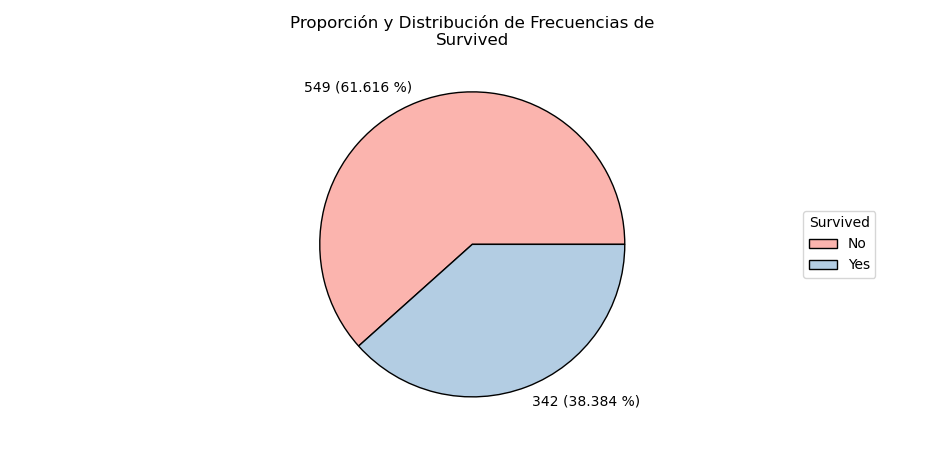

In [10]:
%matplotlib notebook

outputVariableFrequenciesTable, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor1DiscreteVariable(datasetFileEntrenamiento, nombreColumnaSalida, labelAbsoluteFrequency = etiquetaFrecuenciaAbsoluta, labelRelativeFrequency = etiquetaFrecuenciaRelativa, labelGeneralTotal = etiquetaTotalGeneral)
outputVariableNumberValues = len(outputVariableFrequenciesTable) - 1
print("En la variable de salida", nombreColumnaSalida, "se tienen", str(outputVariableNumberValues), "clases")
display(outputVariableFrequenciesTable)

plt.figure(num = 1, figsize = (9.5, 4.5))
plotFrequenciesProportionFor1Variable(outputVariableFrequenciesTable, nombreColumnaSalida, labelAbsoluteFrequency = etiquetaFrecuenciaAbsoluta, labelRelativeFrequency = etiquetaFrecuenciaRelativa)
plt.show()

Survived,No,Yes,General Total
Sex,,,
female,81,233,314
male,468,109,577
General Total,549,342,891


<IPython.core.display.Javascript object>


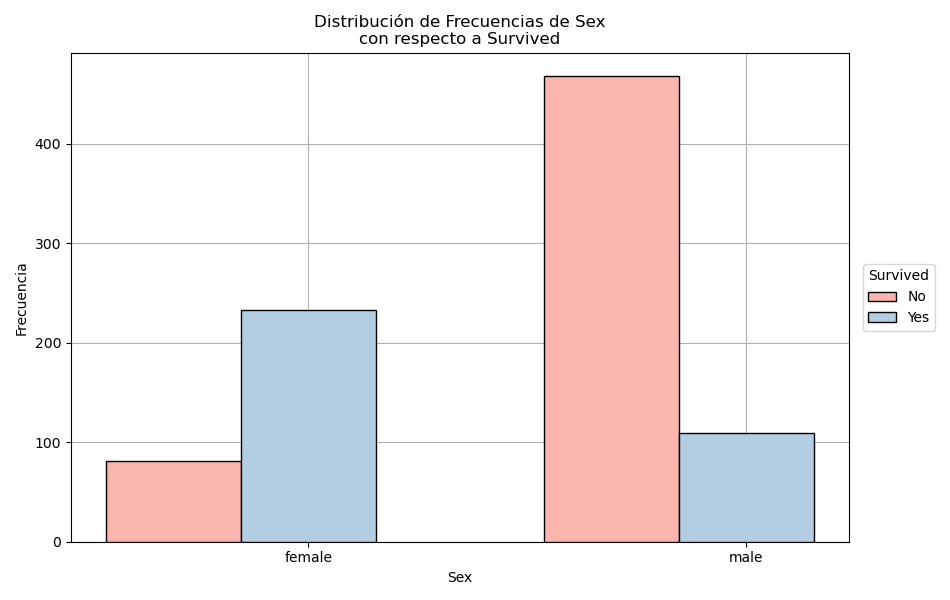

In [11]:
datasetFileEntrenamiento[nombreColumnaDuplicadaSalida] = datasetFileEntrenamiento[nombreColumnaSalida]
pivotTablesList = {}

pivotTablesList["Sex"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor2DiscreteVariables(datasetFileEntrenamiento, nombreColumnaDuplicadaSalida, "Sex", nombreColumnaSalida)
display(pivotTablesList["Sex"])

plt.figure(num = 2, figsize = (9.5, 6))
plotFrequenciesDistributionFor2Variables(pivotTablesList["Sex"], nombreColumnaSalida, "Sex", barWidth = 1.0, barOffset = 0.25, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = etiquetaFrecuencia)
plt.show()

Survived,No,Yes,General Total
Embarked,,,
0,0,2,2
C,75,93,168
Q,47,30,77
S,427,217,644
General Total,549,342,891


<IPython.core.display.Javascript object>


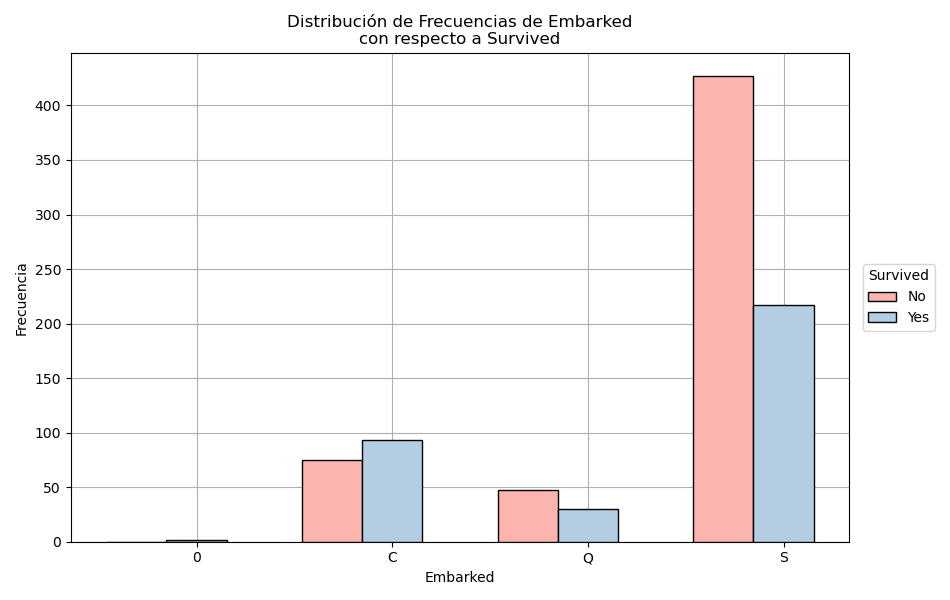

In [12]:
pivotTablesList["Embarked"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor2DiscreteVariables(datasetFileEntrenamiento, nombreColumnaDuplicadaSalida, "Embarked", nombreColumnaSalida)
display(pivotTablesList["Embarked"])

plt.figure(num = 3, figsize = (9.5, 6))
plotFrequenciesDistributionFor2Variables(pivotTablesList["Embarked"], nombreColumnaSalida, "Embarked", barWidth = 1.0, barOffset = 0.25, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = etiquetaFrecuencia)
plt.show()

Survived,No,Yes,General Total
PClass,,,
1,80,136,216
2,97,87,184
3,372,119,491
General Total,549,342,891


<IPython.core.display.Javascript object>


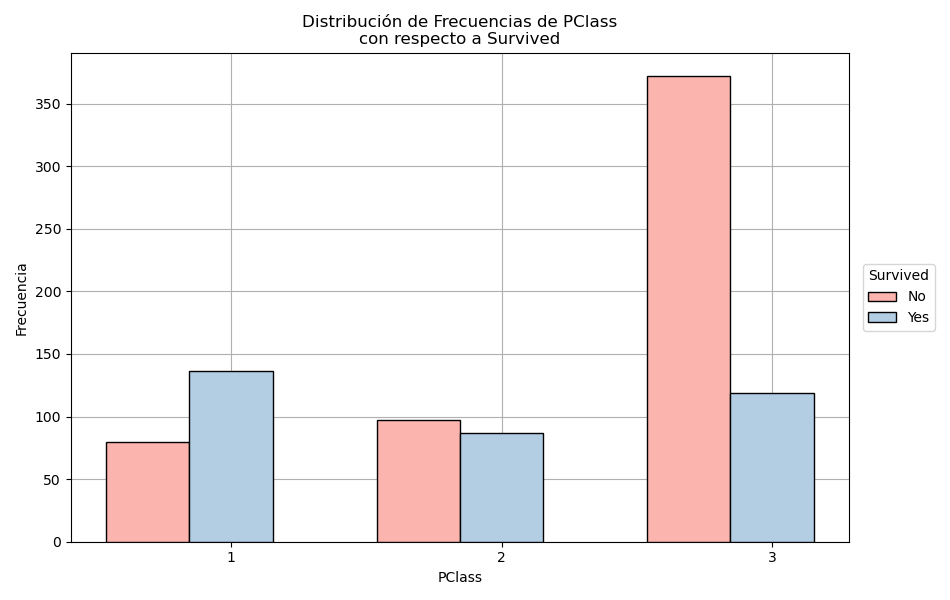

In [13]:
pivotTablesList["PClass"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor2DiscreteVariables(datasetFileEntrenamiento, nombreColumnaDuplicadaSalida, "PClass", nombreColumnaSalida)
display(pivotTablesList["PClass"])

plt.figure(num = 4, figsize = (9.5, 6))
plotFrequenciesDistributionFor2Variables(pivotTablesList["PClass"], nombreColumnaSalida, "PClass", barWidth = 1.0, barOffset = 0.25, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = etiquetaFrecuencia)
plt.show()

Survived,No,Yes,General Total
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
General Total,549,342,891


<IPython.core.display.Javascript object>


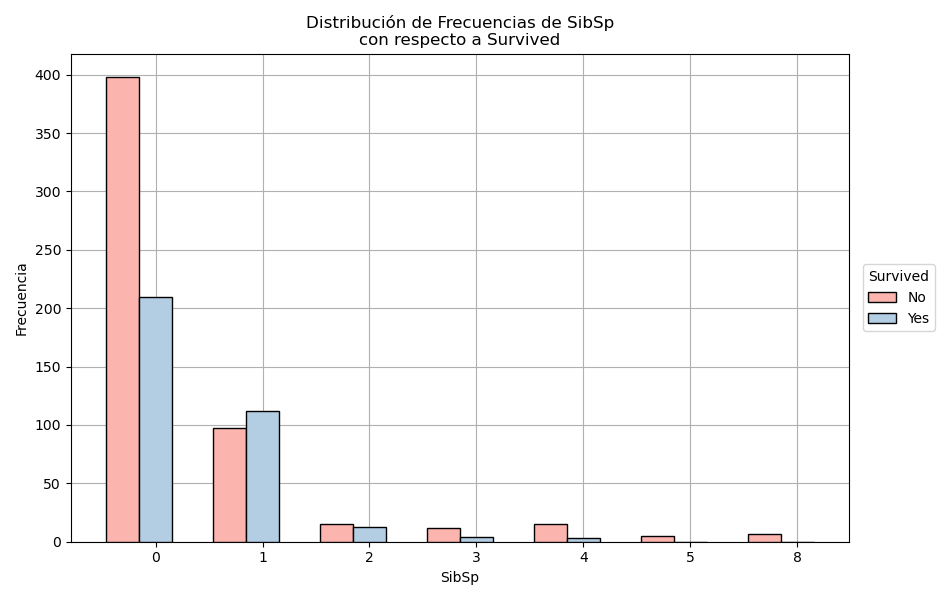

In [14]:
pivotTablesList["SibSp"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor2DiscreteVariables(datasetFileEntrenamiento, nombreColumnaDuplicadaSalida, "SibSp", nombreColumnaSalida)
display(pivotTablesList["SibSp"])

plt.figure(num = 5, figsize = (9.5, 6))
plotFrequenciesDistributionFor2Variables(pivotTablesList["SibSp"], nombreColumnaSalida, "SibSp", barWidth = 1.0, barOffset = 0.25, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = etiquetaFrecuencia)
plt.show()

Survived,No,Yes,General Total
Parch,,,
0,445,233,678
1,53,65,118
2,40,40,80
3,2,3,5
4,4,0,4
5,4,1,5
6,1,0,1
General Total,549,342,891


<IPython.core.display.Javascript object>


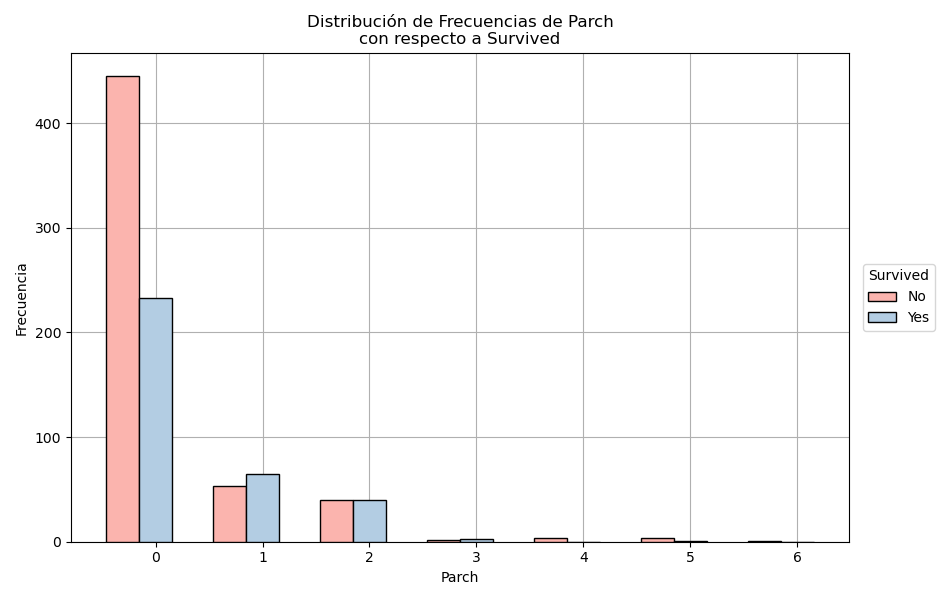

In [15]:
pivotTablesList["Parch"], cellsIndexesWithZeroValuesBySelectedColumns, cellsIndexesWithMaximumValueBySelectedColumns, cellsIndexesWithMinimumValueBySelectedColumns = buildFrequenciesTableFor2DiscreteVariables(datasetFileEntrenamiento, nombreColumnaDuplicadaSalida, "Parch", nombreColumnaSalida)
display(pivotTablesList["Parch"])

plt.figure(num = 6, figsize = (9.5, 6))
plotFrequenciesDistributionFor2Variables(pivotTablesList["Parch"], nombreColumnaSalida, "Parch", barWidth = 1.0, barOffset = 0.25, mainVariableAtLegend = True, verticalOrientation = True, labelFrequency = etiquetaFrecuencia)
plt.show()

In [16]:
datasetFileEntrenamiento.drop([nombreColumnaDuplicadaSalida], axis = 1, inplace = True)

datasetFileEntrenamiento["Sex"] = datasetFileEntrenamiento["Sex"].map({"female": 1, "male": 2})
datasetFileEntrenamiento["Embarked"] = datasetFileEntrenamiento["Embarked"].map({'C': 1, 'Q': 2, 'S': 3})

datasetFileEntrenamiento

,PClass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,1,30.0,0,0,93.5,3.0,Yes
1,1,1,52.0,1,1,93.5,3.0,Yes
2,3,2,29.0,0,0,9.5,3.0,Yes
3,3,2,28.0,0,0,9.5,3.0,No
4,3,2,16.0,0,0,9.5,3.0,No
...,...,...,...,...,...,...,...,...
886,2,2,30.0,0,0,0.0,3.0,No
887,2,2,30.0,0,0,0.0,3.0,No
888,1,2,39.0,0,0,0.0,3.0,No
889,1,2,30.0,0,0,0.0,3.0,No


In [17]:
datasetFilePrueba["Sex"] = datasetFilePrueba["Sex"].map({"female": 1, "male": 2})
datasetFilePrueba["Embarked"] = datasetFilePrueba["Embarked"].map({'C': 1, 'Q': 2, 'S': 3})

datasetFilePrueba

,PClass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,2,34.5,0,0,7.8292,2,No
1,3,1,47.0,1,0,7.0000,3,Yes
2,2,2,62.0,0,0,9.6875,2,No
3,3,2,27.0,0,0,8.6625,3,No
4,3,1,22.0,1,1,12.2875,3,Yes
...,...,...,...,...,...,...,...,...
413,3,2,30.0,0,0,8.0500,3,No
414,1,1,39.0,0,0,108.9000,1,Yes
415,3,2,38.5,0,0,7.2500,3,No
416,3,2,30.0,0,0,8.0500,3,No


In [18]:
# this link will be deprecated
# df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vROQTrW6KKNNGK-Cis139acodD1ZqxrJL3mqpmXjLAXAnXDqNGgX915gXj1nnvfftlaojS-AInQ6Ouv/pub?output=csv')
df = pd.read_csv('train.csv', sep = ";", decimal = ".")
print("tamaño de los datos:", df.shape)
df

tamaño de los datos: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5,B73,S
1,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5,B69,S
2,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5,NaN,S
3,201,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28.0,0,0,345770,9.5,NaN,S
4,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0,NaN,S
887,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0,NaN,S
888,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0,A36,S
889,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0,B102,S


In [19]:
df=df.drop('Cabin', axis=1)
df=df.drop('Ticket', axis=1)
df=df.drop('PassengerId', axis=1)
df=df.drop('Name', axis=1)
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
df['Survived'] = df['Survived'].map({0: 'No', 1: 'Yes'})
df['Embarked'] = df['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})
df.dropna(subset=['Embarked'], inplace=True)
#mean_age = df['Age'].mean()
df['Age'].fillna(30, inplace=True)

In [20]:
# import re
# deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
# data = [df]

# for dataset in data:
#     dataset['Cabin'] = dataset['Cabin'].fillna("U0")
#     dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
#     dataset['Deck'] = dataset['Deck'].map(deck)
#     dataset['Deck'] = dataset['Deck'].fillna(0)
#     dataset['Deck'] = dataset['Deck'].astype(int)
# # we can now drop the cabin feature
# df = df.drop(['Cabin'], axis=1)

In [21]:
df.describe()

,Pclass,Sex,Age,SibSp,Parch,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,0.649044,29.713352,0.524184,0.382452,2.535433
std,0.834700,0.477538,12.969135,1.103705,0.806761,0.792088
min,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,2.000000
50%,3.000000,1.000000,30.000000,0.000000,0.000000,3.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,3.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,3.000000


In [22]:
df.Survived.unique()

array(['Yes', 'No'], dtype=object)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    object 
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    int64  
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    object 
 7   Embarked  889 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [24]:
import matplotlib.pyplot as plt
clases=['Yes','No']

print(df.keys())

"""
for key in df.keys(): # voy a recorrer cada columna de mi DF
    if key != 'Survived': # excepto la de specie
        plt.figure()  # creo una figura
        for tipo in clases: # voy a realizar un for para cada una de las especies
            df[key][df['Survived'] == tipo].plot.hist(alpha = 0.5, bins = 15)
        plt.title(key)
        plt.legend(clases)
plt.show()
"""

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')


"\nfor key in df.keys(): # voy a recorrer cada columna de mi DF\n    if key != 'Survived': # excepto la de specie\n        plt.figure()  # creo una figura\n        for tipo in clases: # voy a realizar un for para cada una de las especies\n            df[key][df['Survived'] == tipo].plot.hist(alpha = 0.5, bins = 15)\n        plt.title(key)\n        plt.legend(clases)\nplt.show()\n"

**Ejercicio**

Realizar tres análisis sobre los datos para comprenderlos

- [Seaborn](https://seaborn.pydata.org/introduction.html)
- [matplotlib](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- interactivas como Bokeh, pygal, plotly [fuente de ejemplos](https://mode.com/blog/python-interactive-plot-libraries/)

**Nota**. puedes usar librerias como [sweetviz](https://github.com/fbdesignpro/sweetviz)
o [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling)

<IPython.core.display.Javascript object>


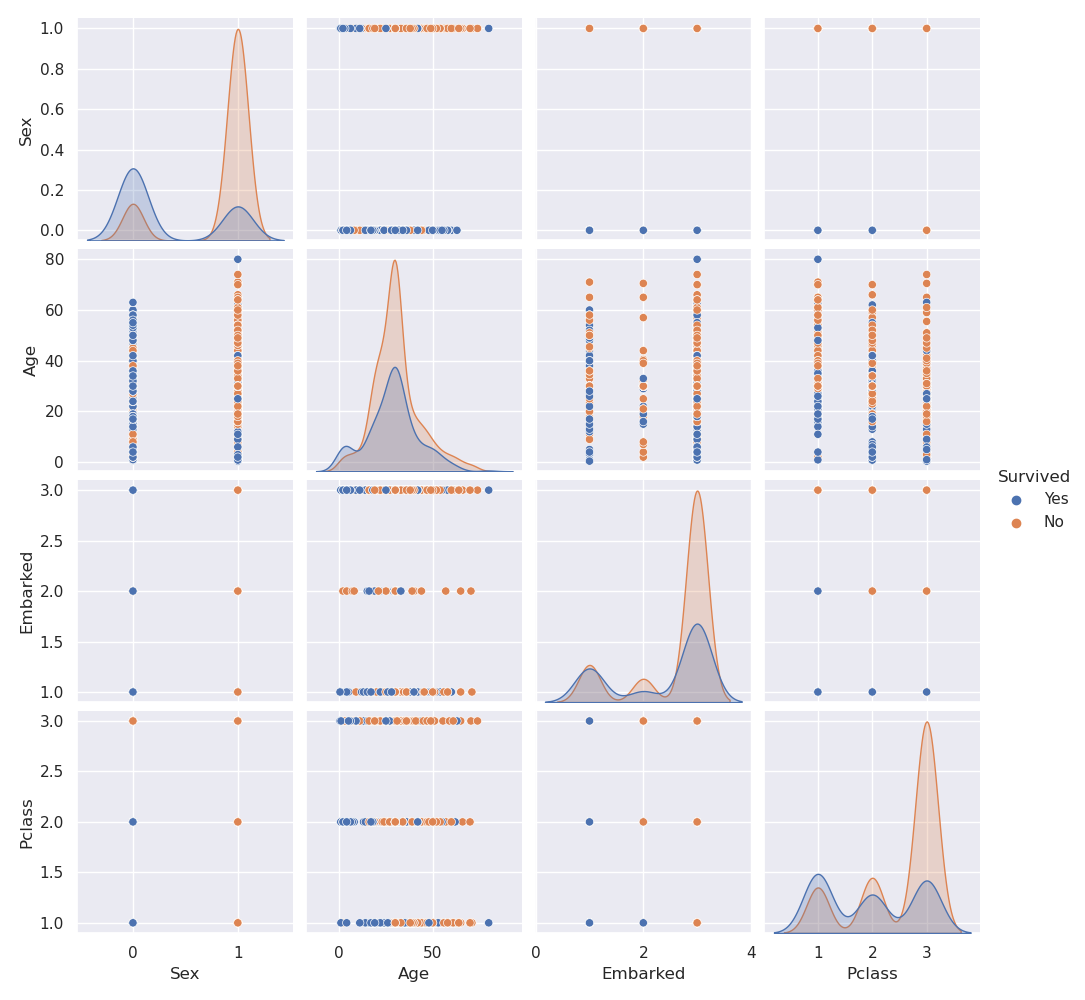

In [25]:
import seaborn as sns
sns.set_theme()

#sns.pairplot(data=df, hue="Survived")
sns.pairplot(data=df, vars = ['Sex', 'Age', 'Embarked', 'Pclass'], hue = 'Survived')

### Preparing the data

Uno de los primeros puntos que se deben tener encuenta es que los datos deben volverse todos numeros.En este punto puede haber muchos pasos (dependiendo del problema) para la limpieza de datos y la eliminación del ruido. El otro paso importante para obtener un modelo necesitaremos minimo dos set de datos(*train* y *test*). En nuestro caso hablaremos de tres(*train,validation and test*).
El objetivo es tener un set para entrenar los modelos (train), otro para comparar cual es mejor que otro y un tercero para sobre el modelo seleccionado probar como se comporta ante nuevos datos


In [26]:
data = [df]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    #dataset['Fare'] = dataset['Fare'].astype(int)

In [27]:
data = [df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

In [28]:
data = [df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']

In [29]:
data = [df]

for dataset in data:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

TypeError: '<=' not supported between instances of 'str' and 'float'

In [ ]:
data = [df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [ ]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
df.head(10)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder() 
df['clases'] = lb.fit_transform(df['Survived'])
df

In [ ]:
#df = df[np.isfinite(df['Fare'])]
X = df[['Pclass','Sex','Age','Fare','Fare_Per_Person','Age_Class','Embarked']]  #vector de entrada X
y = df['clases'] # vector de salidas y
print(X.shape)
print(y.shape)

vamos a usar 20% datos para pruebas(test), y del 80% restante vamos a usar 75% para entrenar (train) y 25% para seleccionar entre los dos modelos que hemos visto (Arboles de decision y Naives-Bayes)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.18, random_state=0)


X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.20, random_state=0)


In [ ]:
y_validate.value_counts()

In [ ]:
df.describe()

## Modeling




### Arboles de decision



In [ ]:
from sklearn.tree import DecisionTreeClassifier

arbol_decision=DecisionTreeClassifier(criterion='entropy', max_depth=10)
arbol_decision.fit(X_train,y_train)
arbol_decision.feature_importances_

In [ ]:
from sklearn import tree
tree.plot_tree(arbol_decision)
plt.show()

### Naives-Bayes


In [ ]:
import sklearn.naive_bayes
naives = sklearn.naive_bayes.GaussianNB()
naives.fit(X_train,y_train)

print('numero de datos por clase',naives.class_count_)
print('probanilidad de clase',naives.class_prior_)
print('media',naives.theta_)
print('desviación estandar**2',naives.var_)

### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train,y_train)

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

### Comparando los modelos

Aqui nos interesa saber cual es mejor para aproximar nuevos datos por lo cual utilizaremos los datos de validacion


#### función analizar resultados

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

def mostrarresultados(clf,X_prueba,y_prueba,titulo,clases):
    print (titulo)
    #score de la respuesta
    print('Media de la exactitud sobre la prueba')
    print(clf.score(X_prueba,y_prueba))

    # matrix de confusion con todos los datos
    y_estimado=clf.predict(X_prueba)
    print('Matrix de confusion')
    m=confusion_matrix( y_prueba,y_estimado)
    print(m)
    print(classification_report(y_prueba, y_estimado, target_names=clases))
    disp = ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clases)
    disp.plot()
    #cuales indicen dan valor diferente
    indices=np.where(((y_estimado)!=(y_prueba)))[0]
    if indices.shape[0]>0:
      print ('datos no detectados correctamente')
      print(indices)
      print ('respuestas reales:')
      print (y_prueba.array[indices])
      print ('respuestas estimadas:')
      print (y_estimado[indices])
      print ('probabilidad de salida(%%):')
      print ('output=0  \t   output=1  \t  output=2')
      print(np.rint(clf.predict_proba(X_prueba.to_numpy()[indices])*100))
      #matriz de datos de entrada de los indices 
      #que fallaron
      print('entradas de los datos que fallaron')
      print(X.to_numpy()[indices])
    else:
      print('todos los datos fueron seleccionados correctamente')

#### Resultados

In [ ]:
mostrarresultados(naives,X_validate,y_validate,'Naives-Bayes',clases)

In [ ]:
mostrarresultados(arbol_decision,X_validate,y_validate,'Decision-Tree',clases)

In [ ]:
mostrarresultados(logistic,X_validate,y_validate,'Logistic Regression',clases)

In [ ]:
mostrarresultados(random_forest,X_validate,y_validate,'Random Forest',clases)

#### Recomendado

No necesita el set de validación pero requiere mas procesamiento

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#from https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scoring =['accuracy',
  'balanced_accuracy',
  'top_k_accuracy',
  'average_precision',
  'neg_brier_score',
  'f1',
  'f1_micro',
  'f1_macro',
  'f1_weighted',
  'f1_samples',
  'neg_log_loss',
  'precision',
  'precision_micro',
  'precision_macro',
  'precision_weighted',
  'precision_samples' 
  'recall',
  'recall_micro',
  'recall_macro',
  'recall_weighted',
  'recall_samples' 
  'jaccard',
  'jaccard_micro',
  'jaccard_macro',
  'jaccard_weighted',
  'jaccard_samples' 
  'roc_auc',
  'roc_auc_ovr',
  'roc_auc_ovo',
  'roc_auc_ovr_weighted',
  'roc_auc_ovo_weighted']

names=['naive bayes','decision tree','logistic','randomForest','----']
models=[sklearn.naive_bayes.GaussianNB(),
                DecisionTreeClassifier(random_state=0),
                LogisticRegression(max_iter=1000),
                RandomForestClassifier()]
my_selected_scoring = 'recall'# put here desired score
for reg,name in zip(models,names):
    scores = cross_val_score(reg, pd.concat([X_train,X_validate]),pd.concat([y_train,y_validate]), scoring=my_selected_scoring,
                            cv=5)
    print('--------------------------------------')
    print('model {0:20} | score {1:20}'.format(name,my_selected_scoring))
    print('mean {0:22.2f}| std   {1:<22.2f}'.format(scores.mean(),scores.std()))
    print("Accuracy(95.7%): {0:10.2f} (+/- {1:.2f})" .format(scores.mean(), scores.std() * 2))

**Ejercicio**

Cual de los dos modelos seleccionar y porque?

## Testing


In [ ]:
mostrarresultados(naives,X_test,y_test,'Random Forest',clases)

**Conclusiones de su modelo**

## Deployment

Como funciona este modelo en producción?

![image.png](https://media.licdn.com/dms/image/C5622AQGAhKGlZjZOKg/feedshare-shrink_800/0/1676565556369?e=1679529600&v=beta&t=7re7vRWDiKXty7iz-wnRwfIqsNNDpA3sDj5b3Mf3xMw)


# TAREA

Tomar alguno de los siguientes set de datos y realizar un clasificador, concluyendo cual fue su mejor modelo y porque?

- [Haberman's Survival Data Set](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)

- [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/)
- [Car safety](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
- [wine](https://archive.ics.uci.edu/ml/datasets/Wine)


Intenta responder estas preguntas:


- ¿Que otras fuentes de información utilizaría para para mejorar la predicción realizada?

- Que transformaciones requirio realizar sobre los datos


- Que modelo sería el mas conveniente? por que?

- cuál es el mejor inidicador de desempeño del modelo de acuerdo a la logica del negocio?

- Alguna implicación etica sobre las decisiones que estaria tomando este clasificador?


- ¿que técnicas de visualización o muestra de resultados aplicó?¿ que queria mostrar con estas gráficas?

